# PyTorch Import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define Hyperparams

In [6]:
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Change Device & Load Data

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Check for device
# device = "mps" if torch.backends.mps.is_available() else "cpu" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("using device ", device)

# Transform for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading MNIST dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


using device  cpu
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



9.9%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Define a simple cnn

In [4]:

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
    self.conv2 = nn.Conv2d(4, 6, kernel_size=3)
    self.fc1 = nn.Linear(6*5*5, 16)  
    self.fc2 = nn.Linear(16, 10)

  def forward(self, x):
    # for mnist, image dim=28
    x= self.conv1(x)
    # now image dim =26
    x = F.relu(F.max_pool2d(x, kernel_size=2))
    # now image dim = 13
    x = self.conv2(x)
    # now image dim = 11
    x = F.relu(F.max_pool2d(x, 2))
    # now image dim = 5
    x = x.view(-1, 6*5*5)  # Flatten with dim 6*5*5
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Initialize the network
model = ConvNet().to(device)


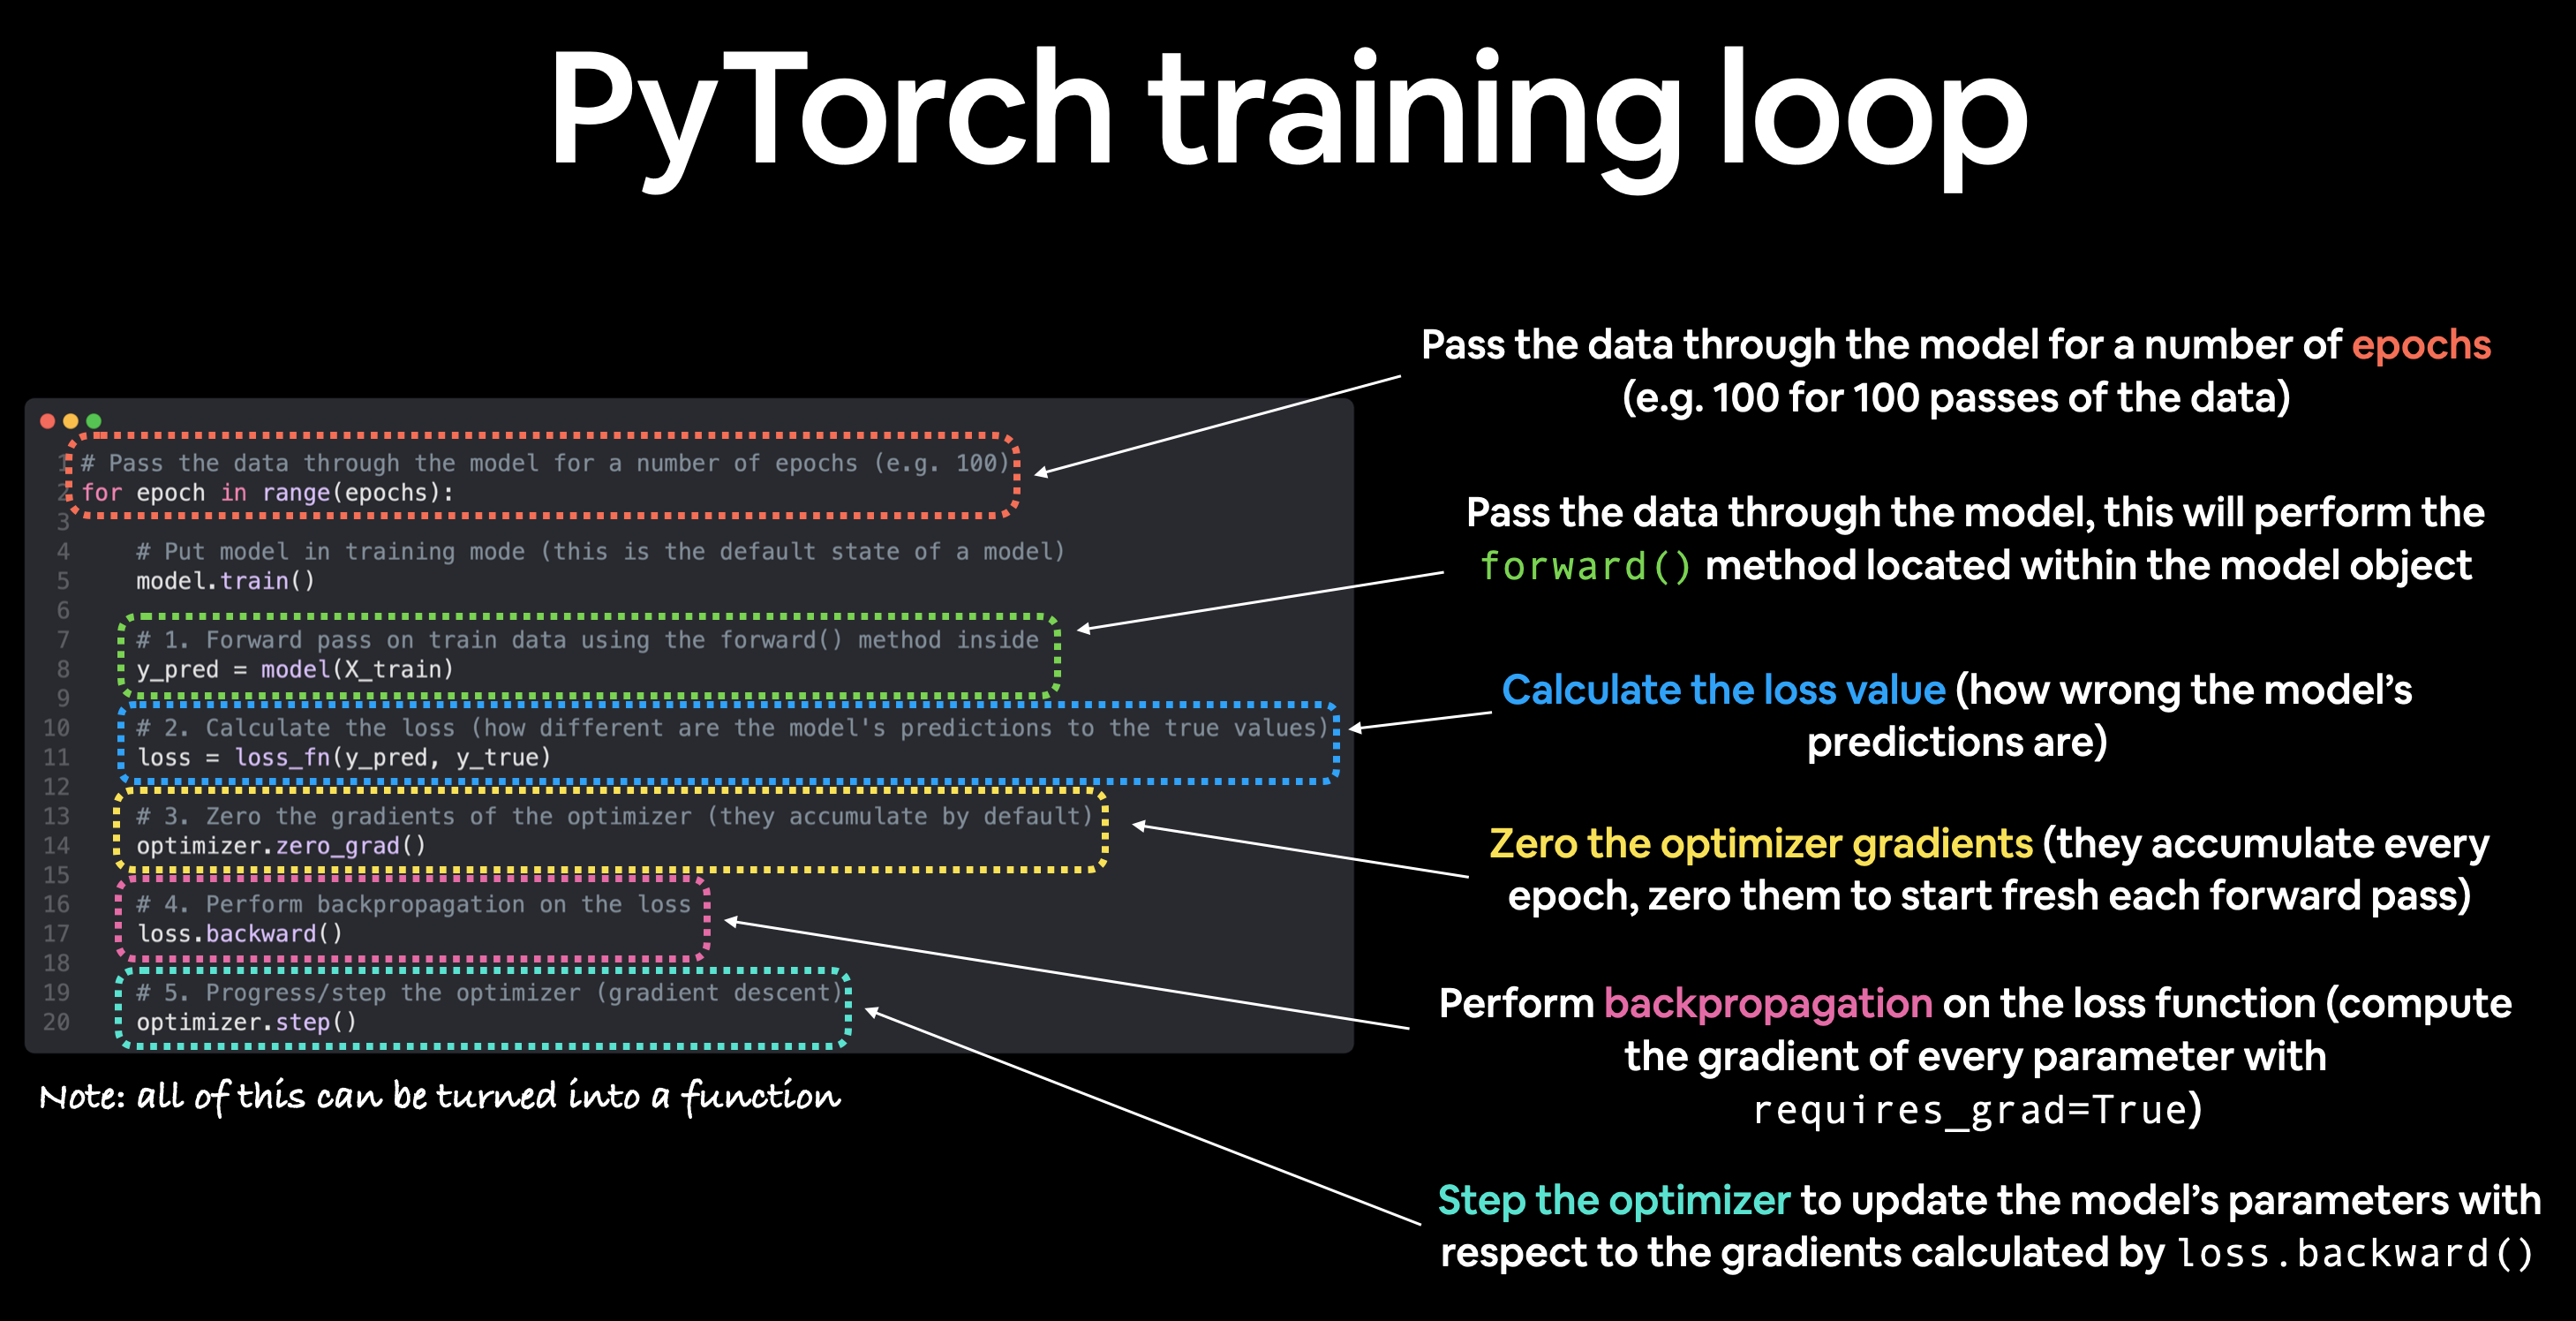

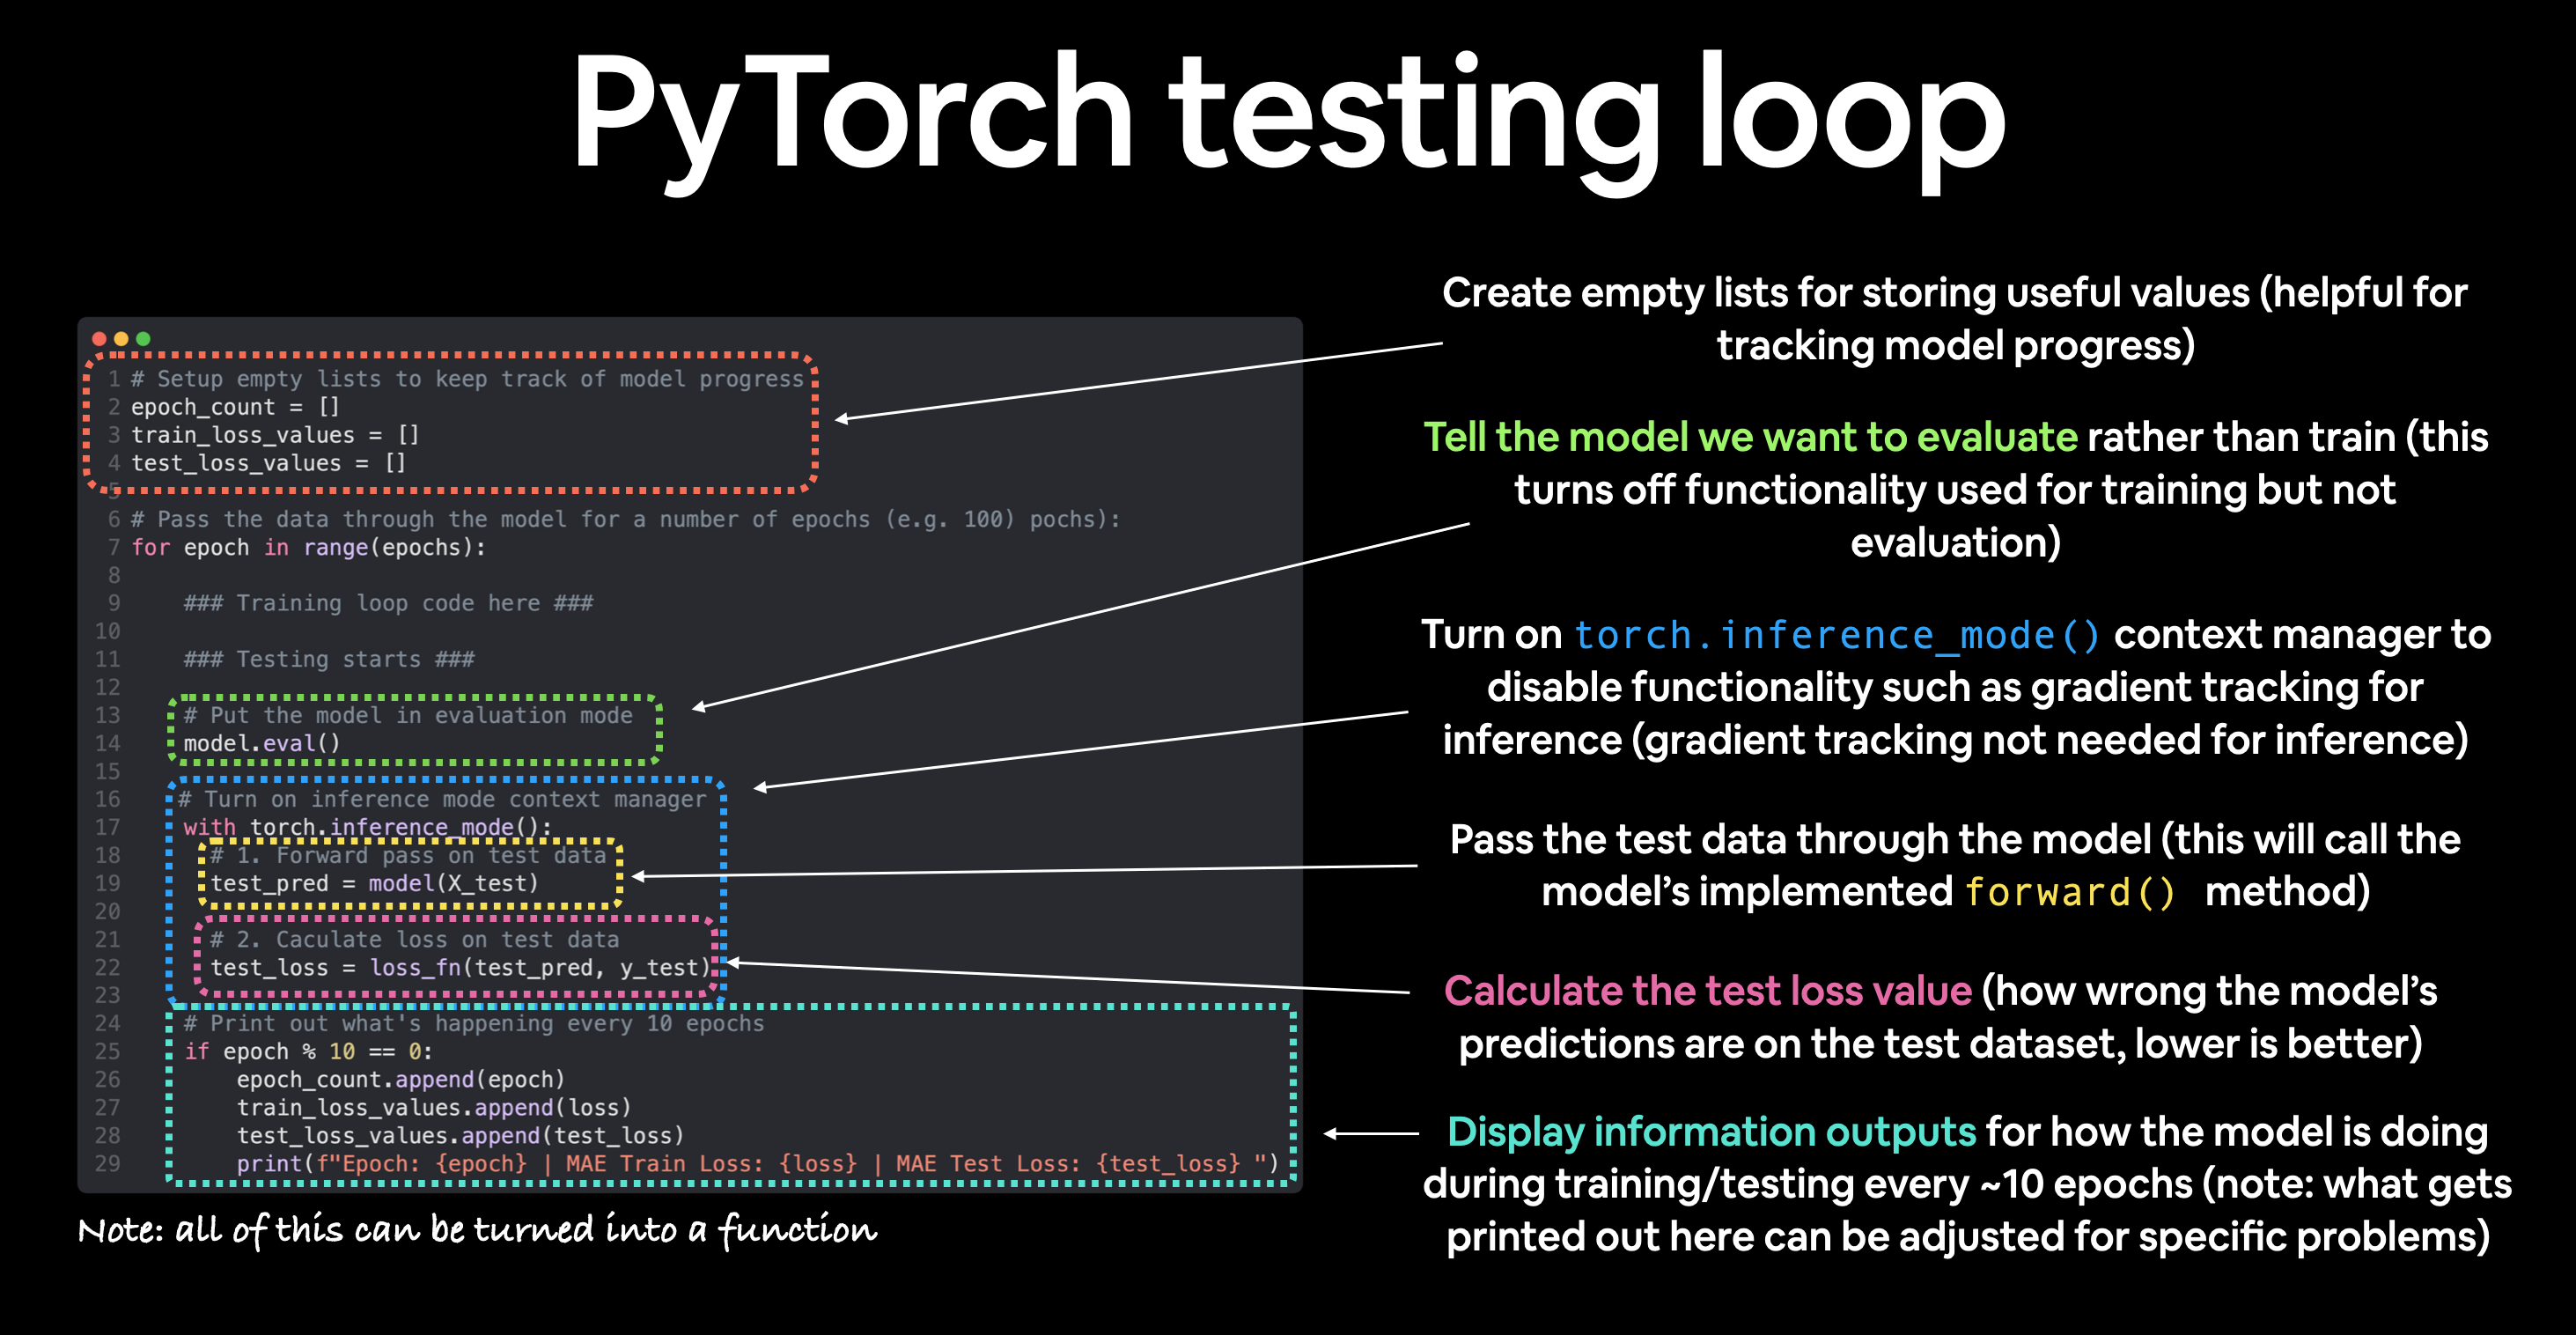

# Training the model using Adam

In [7]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
# scheduler = MultiStepLR(optimizer, milestones=[1], gamma=0.1)

num_batches= int(len(train_set)/batch_size)
model.train()
for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0:
            print(f"Batch [{batch_idx+1}/{num_batches}], Loss: {loss.item():.4f}")
    # scheduler.step()

Batch [100/937], Loss: 0.2777
Batch [200/937], Loss: 0.1012
Batch [300/937], Loss: 0.1954
Batch [400/937], Loss: 0.2758
Batch [500/937], Loss: 0.0887
Batch [600/937], Loss: 0.0460
Batch [700/937], Loss: 0.1927
Batch [800/937], Loss: 0.1370
Batch [900/937], Loss: 0.0419
Batch [100/937], Loss: 0.0709
Batch [200/937], Loss: 0.2637
Batch [300/937], Loss: 0.0452
Batch [400/937], Loss: 0.1377
Batch [500/937], Loss: 0.0293
Batch [600/937], Loss: 0.1928
Batch [700/937], Loss: 0.0759
Batch [800/937], Loss: 0.1974
Batch [900/937], Loss: 0.0646
Batch [100/937], Loss: 0.0991
Batch [200/937], Loss: 0.0421
Batch [300/937], Loss: 0.1821
Batch [400/937], Loss: 0.2239
Batch [500/937], Loss: 0.1986
Batch [600/937], Loss: 0.0389
Batch [700/937], Loss: 0.2675
Batch [800/937], Loss: 0.0934
Batch [900/937], Loss: 0.0543
Batch [100/937], Loss: 0.3305
Batch [200/937], Loss: 0.1043
Batch [300/937], Loss: 0.1222
Batch [400/937], Loss: 0.0559
Batch [500/937], Loss: 0.0901
Batch [600/937], Loss: 0.0547
Batch [700

# Evaluate the model's performance on test data

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')


Accuracy of the network on the 10000 test images: 97%


## save and reload model

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = ConvNet()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Some useful PyTorch functions

## Reshape

In [14]:
# Create a tensor
tensor = torch.arange(8)  # Tensor with values from 0 to 7
print("Original tensor:\n", tensor)

# Reshape the tensor to 2x4 using `view`
view_tensor = tensor.view(2, 4)
print("\nReshaped tensor using view (2x4):\n", view_tensor)

# Reshape the tensor to 2x4 using `reshape`
reshape_tensor = tensor.reshape(2, 4)
print("\nReshaped tensor using reshape (2x4):\n", reshape_tensor)

Original tensor:
 tensor([0, 1, 2, 3, 4, 5, 6, 7])

Reshaped tensor using view (2x4):
 tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])

Reshaped tensor using reshape (2x4):
 tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])


## Matrix Multiplication

In [9]:
A = torch.tensor([[1, 2], [3, 4], [5,6]])  # Shape: (3, 2)
B = torch.tensor([[7], [8]])  # Shape: (2, 1)

# Perform matrix multiplication
C = torch.matmul(A, B)

print("Matrix A:\n", A)
print("Matrix B:\n", B)
print("Result of A x B using torch.matmul:\n", C)

Matrix A:
 tensor([[1, 2],
        [3, 4],
        [5, 6]])
Matrix B:
 tensor([[7],
        [8]])
Result of A x B using torch.matmul:
 tensor([[23],
        [53],
        [83]])


In [ ]:
A_batch = torch.randn(3, 2, 4)  # Shape: (batch_size=3, rows=2, cols=4)
B_batch = torch.randn(3, 4, 5)  # Shape: (batch_size=3, rows=4, cols=5)

# Perform batch matrix multiplication using einsum
C_batch = torch.einsum('bij,bjk->bik', A_batch, B_batch)

## Stack

In [16]:
# Stack tensors on top of each other
x = torch.arange(3)
x_stacked = torch.stack([x, x, x, x], dim=0) 
x_stacked

tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]])

In [17]:
x = torch.arange(3)
x_stacked = torch.stack([x, x, x, x], dim=1) 
x_stacked

tensor([[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]])

## Squeeze and Unsqueeze

### Squeeze: remove all dimensions with size "1"

In [12]:
x = torch.rand(7, 1)
print(f"Previous tensor: {x}")
print(f"Previous shape: {x.shape}")

# Remove extra dimension from x_reshaped
x_squeezed = x.squeeze()
print(f"\nNew tensor: {x_squeezed}")
print(f"New shape: {x_squeezed.shape}")

Previous tensor: tensor([[0.6001],
        [0.0477],
        [0.2444],
        [0.6168],
        [0.3503],
        [0.3585],
        [0.3122]])
Previous shape: torch.Size([7, 1])

New tensor: tensor([0.6001, 0.0477, 0.2444, 0.6168, 0.3503, 0.3585, 0.3122])
New shape: torch.Size([7])


### Unsqueeze: add a dimension value of 1 at a specific index

In [13]:
print(f"Previous tensor: {x_squeezed}")
print(f"Previous shape: {x_squeezed.shape}")

## Add an extra dimension with unsqueeze
x_unsqueezed = x_squeezed.unsqueeze(dim=0)
print(f"\nNew tensor: {x_unsqueezed}")
print(f"New shape: {x_unsqueezed.shape}")

Previous tensor: tensor([0.6001, 0.0477, 0.2444, 0.6168, 0.3503, 0.3585, 0.3122])
Previous shape: torch.Size([7])

New tensor: tensor([[0.6001, 0.0477, 0.2444, 0.6168, 0.3503, 0.3585, 0.3122]])
New shape: torch.Size([1, 7])
